We will begin by preprocessing and performing exploratory data analysis (EDA) on the provided dataset, followed by building and optimizing the prediction model.

### Loading the Dataset

#### Description for the dataset
* There are rows with missing latitudes and longitudes ignore those 
* You have CFR data in all rows and deaths in a few and confirmed cases unknown 
* Deaths you have to predict the gaps and as soon as you have the data for deaths you can get the confirmed cases from CFR ratio 
*  Any exteranl factors that you might think may affect the prediction you can use like temperature or so but you have to provide a clear explaination for the same
* Case fatality ratio= (death / confirmed )* 100
* Provide a single CSV file with all the predictions

In [1]:

import numpy as np
import pandas as pd

train_df = pd.read_csv("data/raw/train_data.csv")


print("Training Dataset is:\n")
print(train_df)

Training Dataset is:

            Lat       Long_  Deaths  Case_Fatality_Ratio
0     33.939110   67.709953     NaN             3.779217
1     41.153300   20.168300     NaN             1.077234
2     28.033900    1.659600     NaN             2.536905
3     42.506300    1.521800   165.0             0.345543
4    -11.202700   17.873900     NaN             1.836434
...         ...         ...     ...                  ...
4011  31.952200   35.233200     NaN             0.811686
4012  39.904200  116.407400     0.0             0.000000
4013  15.552727   48.516388     NaN            18.074508
4014 -13.133897   27.849332     NaN             1.201603
4015 -19.015438   29.154857     NaN             2.168235

[4016 rows x 4 columns]


In [2]:
test_df = pd.read_csv("data/raw/test_data.csv")

# Printing Training Dataset
print("Testing Dataset is:\n")
print(test_df)

Testing Dataset is:

            Lat       Long_
0     41.153300   20.168300
1    -71.949900   23.347000
2    -35.473500  149.012400
3    -34.928500  138.600700
4     47.516200   14.550100
...         ...         ...
999   49.213800   -2.135800
1000  -7.946700  -14.355900
1001  52.130700   -3.783700
1002   6.423800  -66.589700
1003  15.552727   48.516388

[1004 rows x 2 columns]


### Seeing Columns of the dataset

In [3]:
print("Training Dataset Columns:\n")
print(train_df.columns)

print("\nTesting Dataset Columns:\n")
print(test_df.columns)

Training Dataset Columns:

Index(['Lat', 'Long_', 'Deaths', 'Case_Fatality_Ratio'], dtype='object')

Testing Dataset Columns:

Index(['Lat', 'Long_'], dtype='object')


### Seeing Descriptive Statistics

In [4]:
print("Training Dataset Columns Description:\n")
print(train_df.describe)

print("\nTesting Dataset Columns Description:\n")
print(test_df.describe)

Training Dataset Columns Description:

<bound method NDFrame.describe of             Lat       Long_  Deaths  Case_Fatality_Ratio
0     33.939110   67.709953     NaN             3.779217
1     41.153300   20.168300     NaN             1.077234
2     28.033900    1.659600     NaN             2.536905
3     42.506300    1.521800   165.0             0.345543
4    -11.202700   17.873900     NaN             1.836434
...         ...         ...     ...                  ...
4011  31.952200   35.233200     NaN             0.811686
4012  39.904200  116.407400     0.0             0.000000
4013  15.552727   48.516388     NaN            18.074508
4014 -13.133897   27.849332     NaN             1.201603
4015 -19.015438   29.154857     NaN             2.168235

[4016 rows x 4 columns]>

Testing Dataset Columns Description:

<bound method NDFrame.describe of             Lat       Long_
0     41.153300   20.168300
1    -71.949900   23.347000
2    -35.473500  149.012400
3    -34.928500  138.600700
4   

### Handling Missing Values

#### Explanation
1. **Handling Missing Latitudes and Longitudes**:
   - Rows with missing `latitude` (`Lat`) and `longitude` (`Long_`) are dropped using `dropna()` to ensure data consistency and integrity. These columns are essential for geographical analysis, and missing values could lead to inaccuracies.

2. **Filling Missing Deaths**:
   - Missing `deaths` values are filled using **linear interpolation**. This method estimates the missing values based on the trend in surrounding rows. It ensures a smoother dataset by imputing values proportionally rather than leaving them empty.
   - Alternative methods such as **forward fill** (`ffill`) or **mean imputation** could also be applied depending on the specific use case.

3. **Calculating Confirmed Cases**:
   - `confirmed_cases` are calculated using the **Case Fatality Ratio (CFR)** formula:
     
        **Case Fatality Ratio (CFR):**  
        CFR = (deaths / confirmed cases) × 100
     
     - Rearranged to calculate `confirmed_cases`:
       
        **Confirmed Cases** = (deaths / CFR) × 100
     
   - If the `Case_Fatality_Ratio` is missing or zero, the confirmed cases are set to `0` to avoid division errors or invalid data.

#### Code Workflow
- **Latitude and Longitude Handling**:  
   The `fill_missing_lat_lon` function removes rows with missing `Lat` or `Long_` values.
- **Deaths and Confirmed Cases Handling**:  
   The `fill_missing_deaths_and_cases` function interpolates missing death values and computes confirmed cases based on the `Case_Fatality_Ratio` column. If CFR is missing or zero, confirmed cases are set to `0` as a fallback.

#### Workflow Summary
- Missing value counts are printed both **before** and **after** preprocessing for transparency.
- The same steps are applied to both `train_df` and `test_df`.  
- For the testing dataset (`test_df`), confirmed cases calculation is skipped because the required columns are not present.

In [5]:
# Remove rows with missing Lat and Long_
def fill_missing_lat_lon(df):
    
    df = df.dropna(subset=['Lat', 'Long_'])
    return df


def fill_missing_deaths_and_cases(df):
    
    
    if 'Deaths' in df.columns:
        df['Deaths'] = df['Deaths'].interpolate(method='linear', limit_direction='both')

    # Calculate confirmed cases from Case Fatality Ratio
    if 'Case_Fatality_Ratio' in df.columns:
        df['Confirmed_Cases'] = df.apply(
            lambda row: (row['Deaths'] / row['Case_Fatality_Ratio'] * 100)
            if not pd.isnull(row['Deaths']) and not pd.isnull(row['Case_Fatality_Ratio']) and row['Case_Fatality_Ratio'] != 0
            else pd.NA,  # Replace with NA if calculation is not possible
            axis=1
        )
    
    
    df = df.dropna(subset=['Confirmed_Cases'])
    
    return df

In [6]:


# Print missing value counts before handling
print("Training Data Missing values before:")
print(train_df.isnull().sum())
print(f"total data length train data before cleaning {len(train_df)}")

print("\nPreprocessing for train_df:")
train_df = fill_missing_lat_lon(train_df)
train_df = fill_missing_deaths_and_cases(train_df)


print("\nTraining Data Missing values after:")
print(train_df.isnull().sum())
print(f"total data length train data after cleaning {len(train_df)}")

# Print missing value counts before handling
print("\nTesting Data Missing values before:")
print(test_df.isnull().sum())
print(f"total data length test data before cleaning {len(test_df)}")

print("\nPreprocessing for test_df:")
test_df = fill_missing_lat_lon(test_df)


print("\nTesting Data Missing values after:")
print(test_df.isnull().sum())
print(f"total data length test data after cleaning {len(test_df)}")

Training Data Missing values before:
Lat                      91
Long_                    91
Deaths                 1558
Case_Fatality_Ratio      44
dtype: int64
total data length train data before cleaning 4016

Preprocessing for train_df:

Training Data Missing values after:
Lat                    0
Long_                  0
Deaths                 0
Case_Fatality_Ratio    0
Confirmed_Cases        0
dtype: int64
total data length train data after cleaning 3808

Testing Data Missing values before:
Lat      23
Long_    23
dtype: int64
total data length test data before cleaning 1004

Preprocessing for test_df:

Testing Data Missing values after:
Lat      0
Long_    0
dtype: int64
total data length test data after cleaning 981


### Converting Latitude and longitude to numeric values

In [7]:
# Convert Lat and Long_ columns to float type for both datasets
train_df['Latitude'] = train_df['Lat'].astype(float)
train_df['Longitude'] = train_df['Long_'].astype(float)

test_df['Latitude'] = test_df['Lat'].astype(float)
test_df['Longitude'] = test_df['Long_'].astype(float)


train_df.drop(columns=['Lat', 'Long_'], inplace=True)
test_df.drop(columns=['Lat', 'Long_'], inplace=True)


print("Training DataFrame:")
print(train_df)

print("\nTesting DataFrame:")
print(test_df)

Training DataFrame:
      Deaths  Case_Fatality_Ratio Confirmed_Cases   Latitude   Longitude
0      165.0             3.779217     4365.984077  33.939110   67.709953
1      165.0             1.077234     15317.01057  41.153300   20.168300
2      165.0             2.536905     6503.987791  28.033900    1.659600
3      165.0             0.345543    47751.000004  42.506300    1.521800
4       82.5             1.836434     4492.402849 -11.202700   17.873900
...      ...                  ...             ...        ...         ...
4010     7.0             0.374700     1868.161835  14.058324  108.277199
4011     3.5             0.811686      431.201472  31.952200   35.233200
4013     0.0            18.074508             0.0  15.552727   48.516388
4014     0.0             1.201603             0.0 -13.133897   27.849332
4015     0.0             2.168235             0.0 -19.015438   29.154857

[3808 rows x 5 columns]

Testing DataFrame:
       Latitude   Longitude
0     41.153300   20.168300
1  

### Saving Preprocessed and cleaned CSV Files

In [8]:
import os

# Create the 'data/interim' directory if it doesn't exist
interim_dir = 'data/interim'
os.makedirs(interim_dir, exist_ok=True)


train_df.to_csv(os.path.join(interim_dir, 'train_data.csv'), index=False)
test_df.to_csv(os.path.join(interim_dir, 'test_data.csv'), index=False)

print("Preprocessed CSV files saved to 'data/interim' directory.")

Preprocessed CSV files saved to 'data/interim' directory.


### Exploratory Data Analysis

### Reading Cleaned data

In [9]:
import pandas as pd


import warnings
warnings.filterwarnings("ignore")

train_df = pd.read_csv("data/interim/train_data.csv")

test_df = pd.read_csv("data/interim/test_data.csv")

In [10]:
# Display all columns for better visibility
pd.set_option('display.max_columns', None)


def eda_train_df(df):
    """Performs EDA on the training dataset."""
    
    # Display basic information and missing values
    print("Training Data Information:")
    print(df.info())
    print("\nColumns of Dataset:")
    print(df.columns)
    print("\nMissing Values in Training Data:")
    print(df.isnull().sum())
    
    
    print("\nDescriptive Statistics for Numerical Columns in Training Data:")
    print(df.describe())


def eda_test_df(df):
    """Performs EDA on the testing dataset."""
    
    # Display basic information and missing values
    print("Testing Data Information:")
    print(df.info())
    print("\nMissing Values in Testing Data:")
    print(df.isnull().sum())
    print("\nColumns of Dataset:")
    print(df.columns)


print("EDA for Training Dataset:")
eda_train_df(train_df)

print("\nEDA for Testing Dataset:")
eda_test_df(test_df)

EDA for Training Dataset:
Training Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Deaths               3808 non-null   float64
 1   Case_Fatality_Ratio  3808 non-null   float64
 2   Confirmed_Cases      3808 non-null   float64
 3   Latitude             3808 non-null   float64
 4   Longitude            3808 non-null   float64
dtypes: float64(5)
memory usage: 148.9 KB
None

Columns of Dataset:
Index(['Deaths', 'Case_Fatality_Ratio', 'Confirmed_Cases', 'Latitude',
       'Longitude'],
      dtype='object')

Missing Values in Training Data:
Deaths                 0
Case_Fatality_Ratio    0
Confirmed_Cases        0
Latitude               0
Longitude              0
dtype: int64

Descriptive Statistics for Numerical Columns in Training Data:
            Deaths  Case_Fatality_Ratio  Confirmed_Cases     Latitude  \


### Exploratory Data Analysis (EDA)

**Explanation:**
1. **Training Data**: 
   - The training dataset contains columns for `Deaths`, `Case_Fatality_Ratio`, `Confirmed_Cases`, `Latitude`, and `Longitude`. This allows for deeper analysis of the relationship between deaths, confirmed cases, and geographic coordinates.
   
2. **Testing Data**:
   - The testing dataset consists of only `Latitude` and `Longitude` columns. Without additional information on cases or deaths, we can focus on geospatial analysis.

We can visualize the datasets through various plots. Here are some visualizations that can be insightful:

- **Geospatial Visualization**: For mapping locations based on `Latitude` and `Longitude`, we can use a plot like a **scatter plot** for geographic distribution or a **geoplot**.
- **Line Plot**: To visualize trends over time for the `Deaths` and `Confirmed_Cases`.
- **Bar Plot**: To show the distribution of `Deaths` or `Confirmed_Cases` across different latitude and longitude intervals.

### Explanation of Visualizations:

1. **Geospatial Data Plot**: 
   - We use **GeoPandas** to plot the geospatial locations based on `Latitude` and `Longitude`. This will give you a clear geographic distribution of the locations in both datasets.

2. **Line Plot**:
   - A **line plot** is created to show the trends between `Deaths` and `Confirmed_Cases`. This works well if the data has any sort of temporal order or index.

3. **Bar Plot by Latitude Intervals**:
   - This bar plot shows the total deaths aggregated by latitude intervals (10-degree intervals). This will give insight into how deaths are distributed across various latitudes.


========= Visualizing for Training Data ==========


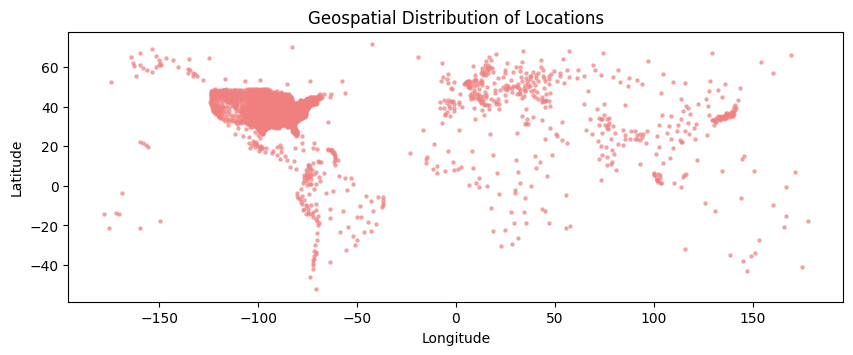

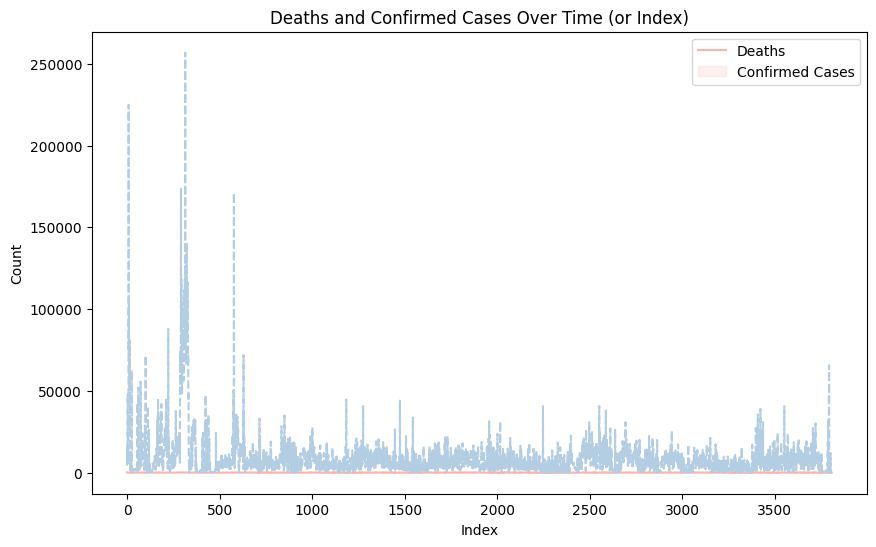

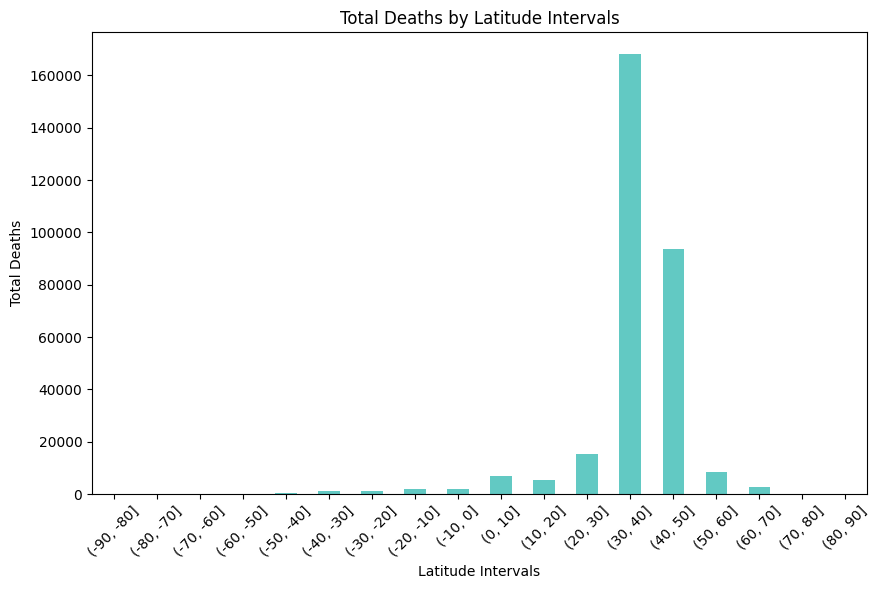


========= Visualizing for Testing Data ===========


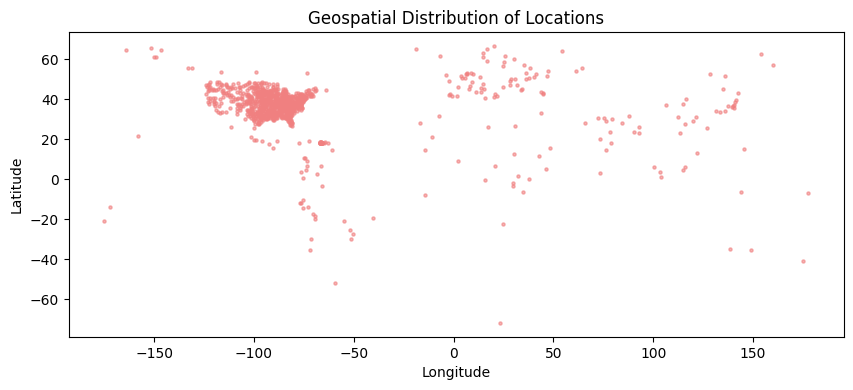

In [11]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point


def plot_geospatial_data(df):
    """Visualize data on a geographical plot."""
    # Create a GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)

    # Plot the geographical distribution
    geo_df.plot(marker='o', color='lightcoral', markersize=5, figsize=(10, 6), alpha=0.6)
    plt.title("Geospatial Distribution of Locations")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


def plot_line_deaths_confirmed(df):
    """Plot line graph of Deaths vs. Confirmed Cases."""
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df[['Deaths', 'Confirmed_Cases']], palette='Pastel1')
    plt.title("Deaths and Confirmed Cases Over Time (or Index)")
    plt.xlabel("Index")
    plt.ylabel("Count")
    plt.legend(["Deaths", "Confirmed Cases"])
    plt.show()

# Bar plot for distribution of deaths or confirmed cases by latitude intervals
def plot_bar_deaths_by_latitude(df):
    """Plot bar graph for distribution of deaths by latitude intervals."""
    # Group by Latitude intervals (e.g., 10 degree bins)
    df['Latitude_Binned'] = pd.cut(df['Latitude'], bins=range(-90, 91, 10))
    deaths_by_lat = df.groupby('Latitude_Binned')['Deaths'].sum()

    # Plotting
    plt.figure(figsize=(10, 6))
    deaths_by_lat.plot(kind='bar', color='lightseagreen', alpha=0.7)
    plt.title("Total Deaths by Latitude Intervals")
    plt.xlabel("Latitude Intervals")
    plt.ylabel("Total Deaths")
    plt.xticks(rotation=45)
    plt.show()


print("\n========= Visualizing for Training Data ==========")
plot_geospatial_data(train_df)
plot_line_deaths_confirmed(train_df)
plot_bar_deaths_by_latitude(train_df)

print("\n========= Visualizing for Testing Data ===========")
plot_geospatial_data(test_df)

### Plots:
1. **Aggregated Deaths by Longitude**: This plot will display the total deaths aggregated by longitude intervals.
2. **Distribution of Case Fatality Ratio (CFR) by Latitude**: A bar plot showing the distribution of CFR across latitude intervals.
3. **Distribution of Deaths Over Longitude**: This will visualize how deaths are distributed geographically across longitude values.

### Detailed Explanation for the Plots:

#### 1. **Aggregated Deaths by Longitude (Bar Plot)**:
   - **Purpose**: This plot displays how total deaths are distributed geographically along the longitudinal axis. It helps identify if deaths are more concentrated in any specific longitudinal region.

#### 2. **Distribution of Case Fatality Ratio (CFR) by Latitude (Bar Plot)**:
   - **Purpose**: This plot shows how the average Case Fatality Ratio (CFR) varies across different latitude intervals. It helps in understanding how CFR behaves in different geographical regions.
   

#### 3. **Distribution of Deaths Over Longitude (Line Plot)**:
   - **Purpose**: This line plot visualizes how deaths are distributed across different longitudes. It allows us to observe any patterns or trends over the longitudinal axis.
   
---

### Summary of Visualizations:
- The **Bar plots** provide insights into the distribution of deaths and CFR across geographical intervals (latitude and longitude).
- The **Line plot** provides a smooth overview of how deaths vary with longitude.


========= Visualizing for Aggregated Training Data ==========


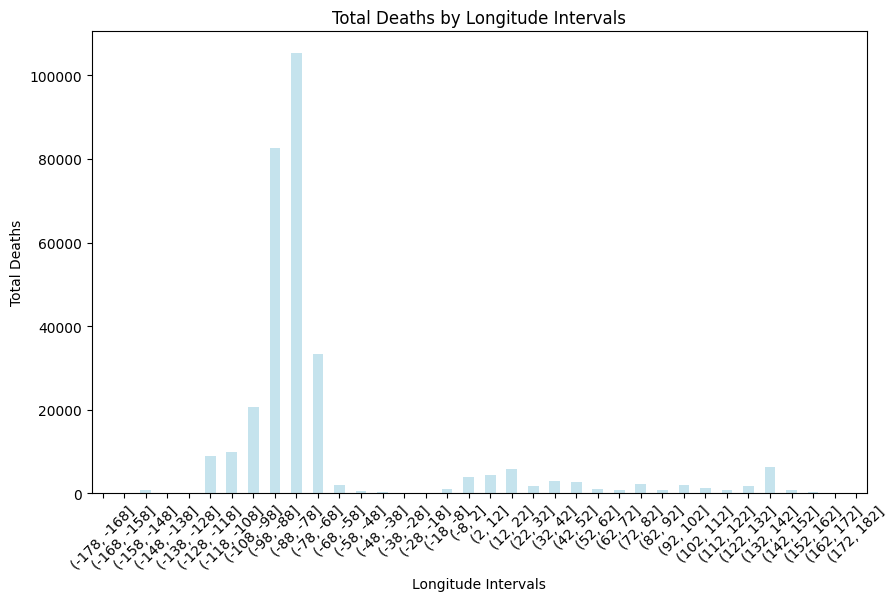

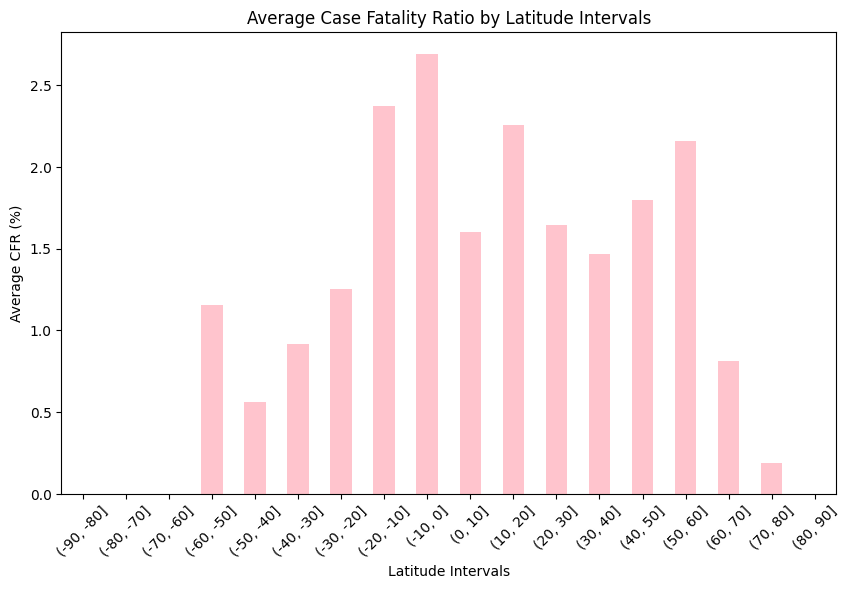

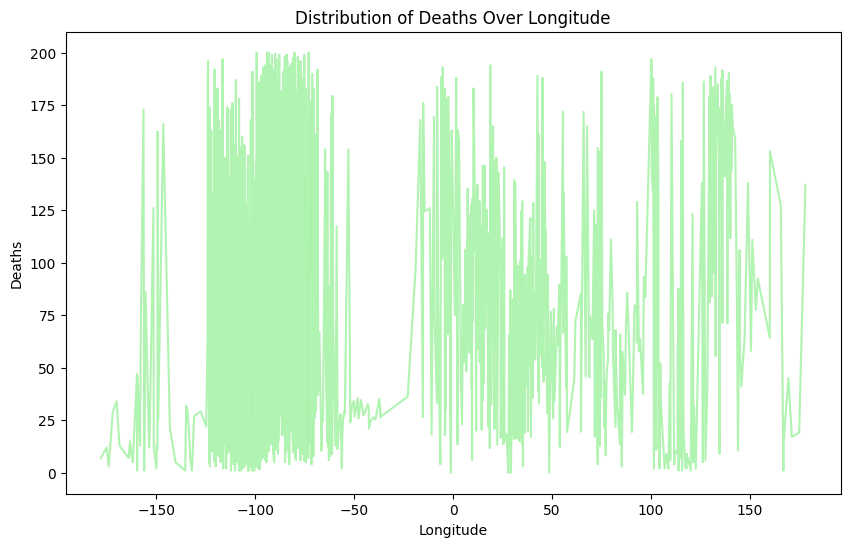

In [12]:
# Aggregated Deaths by Longitude
def plot_bar_deaths_by_longitude(df):
    """Plot bar graph for distribution of deaths by longitude intervals."""
    
    df['Longitude_Binned'] = pd.cut(df['Longitude'], bins=range(int(df['Longitude'].min()), int(df['Longitude'].max()) + 10, 10))
    deaths_by_long = df.groupby('Longitude_Binned')['Deaths'].sum()

   
    plt.figure(figsize=(10, 6))
    deaths_by_long.plot(kind='bar', color='lightblue', alpha=0.7)
    plt.title("Total Deaths by Longitude Intervals")
    plt.xlabel("Longitude Intervals")
    plt.ylabel("Total Deaths")
    plt.xticks(rotation=45)
    plt.show()
    

def plot_bar_cfr_by_latitude(df):
    """Plot bar graph for distribution of Case Fatality Ratio (CFR) by latitude intervals."""
    # Group by Latitude intervals (e.g., 10 degree bins)
    df['Latitude_Binned'] = pd.cut(df['Latitude'], bins=range(-90, 91, 10))
    cfr_by_lat = df.groupby('Latitude_Binned')['Case_Fatality_Ratio'].mean()

    
    plt.figure(figsize=(10, 6))
    cfr_by_lat.plot(kind='bar', color='lightpink', alpha=0.8)
    plt.title("Average Case Fatality Ratio by Latitude Intervals")
    plt.xlabel("Latitude Intervals")
    plt.ylabel("Average CFR (%)")
    plt.xticks(rotation=45)
    plt.show()

# Distribution of Deaths Over Longitude
def plot_line_deaths_over_longitude(df):
    """Plot line graph for distribution of deaths over longitude."""
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Longitude', y='Deaths', color='lightgreen', alpha=0.7)
    plt.title("Distribution of Deaths Over Longitude")
    plt.xlabel("Longitude")
    plt.ylabel("Deaths")
    plt.show()


print("\n========= Visualizing for Aggregated Training Data ==========")
plot_bar_deaths_by_longitude(train_df)
plot_bar_cfr_by_latitude(train_df)
plot_line_deaths_over_longitude(train_df)


### **Explanation of the Code**
This Python script aims to preprocess training data, train and evaluate multiple regression models, compare their performances for two target variables (Deaths and Case Fatality Ratio), and save the best models with their evaluation metrics. The script is designed to facilitate end-to-end model development, from preprocessing to deployment-ready model saving.

---

### **Function Descriptions**

#### 1. **`preprocess_training_data(data)`**
   - **Purpose**: Prepares the dataset for modeling by cleaning and splitting it into features and target variables.

---

#### 2. **`train_and_evaluate_all_models(X_train, y_deaths_train, y_cfr_train)`**
   - **Purpose**: Trains and evaluates multiple regression models on training data for predicting `Deaths` and `CFR`.
   - **Steps**:
     - Defines a dictionary of regression models: Linear Regression, Random Forest, SVR, Gradient Boosting, Decision Tree, K-Nearest Neighbors, and AdaBoost.
     - For each model:
       1. Trains on `Deaths` and evaluates its performance using Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score.
       2. Trains on `CFR` and evaluates the same metrics.
     - Stores results in a list of dictionaries.
   - **Returns**:
     - A DataFrame containing evaluation metrics (MAE, MSE, R²) for all models.

---

#### 3. **`plot_model_comparison(results_df)`**
   - **Purpose**: Visualizes the performance of all models using bar plots.
   - **Steps**:
     - Plots `MAE` and `R²` scores for `Deaths` and `CFR` predictions using Seaborn.
     - Helps identify the best-performing models visually.
   - **Expected Input**: DataFrame containing metrics like `Deaths_MAE`, `Deaths_R2`, `CFR_MAE`, and `CFR_R2`.

---

#### 4. **`save_evaluation_metrics_to_csv(results_df, file_path="models/evaluation_metrics.csv")`**
   - **Purpose**: Saves the evaluation metrics DataFrame to a CSV file.
   - **Steps**:
     - Writes the DataFrame `results_df` to the specified file path.
   - **Output**:
     - A CSV file containing the evaluation metrics for future reference.

---

#### 5. **`save_model_with_filename(model, model_name, metric_name)`**
   - **Purpose**: Saves the trained model with a descriptive filename that includes the model name and evaluation metric.
   - **Steps**:
     - Uses `pickle` and `joblib` to save the model.
     - Generates filenames based on the model name and a key metric (e.g., R² score).
   - **Output**:
     - Serialized model files for deployment or later use.

---

### **Main Workflow**

1. **Preprocessing**:
   - The dataset is cleaned and split into features (`Latitude`, `Longitude`) and targets (`Deaths`, `CFR`) using `preprocess_training_data`.

2. **Data Splitting**:
   - The data is split into training and testing sets using `train_test_split`.

3. **Model Training and Evaluation**:
   - Multiple regression models are trained and evaluated using the `train_and_evaluate_all_models` function.
   - The evaluation metrics (MAE, MSE, R²) are stored in a DataFrame.

4. **Visualization**:
   - The `plot_model_comparison` function generates bar plots to compare model performances visually.

5. **Save Evaluation Results**:
   - The evaluation metrics are saved as a CSV file for future reference.

6. **Select Best Models**:
   - The best models for `Deaths` and `CFR` are selected based on the highest R² scores.

7. **Final Evaluation**:
   - The best models are evaluated on the test set to verify their generalization performance.

8. **Save Best Models**:
   - The best models are serialized and saved using `save_model_with_filename`.

                 Model  Deaths_MAE   Deaths_MSE  Deaths_R2   CFR_MAE  \
0    Linear Regression   43.263886  2625.765718   0.004933  1.006661   
1        Random Forest   12.997623   281.023518   0.893503  0.399319   
2                  SVR   41.127714  2504.950667   0.050717  0.729752   
3    Gradient Boosting   33.490797  1697.820787   0.356589  0.442241   
4        Decision Tree    0.000000     0.000000   1.000000  0.000000   
5  K-Nearest Neighbors   28.568042  1348.983083   0.488786  0.734198   
6             AdaBoost   39.614105  2180.966850   0.173495  0.524620   

      CFR_MSE    CFR_R2  
0  123.804301  0.003412  
1   31.108206  0.749588  
2  124.627757 -0.003217  
3    0.477050  0.996160  
4    0.000000  1.000000  
5  100.116675  0.194090  
6    0.643661  0.994819  


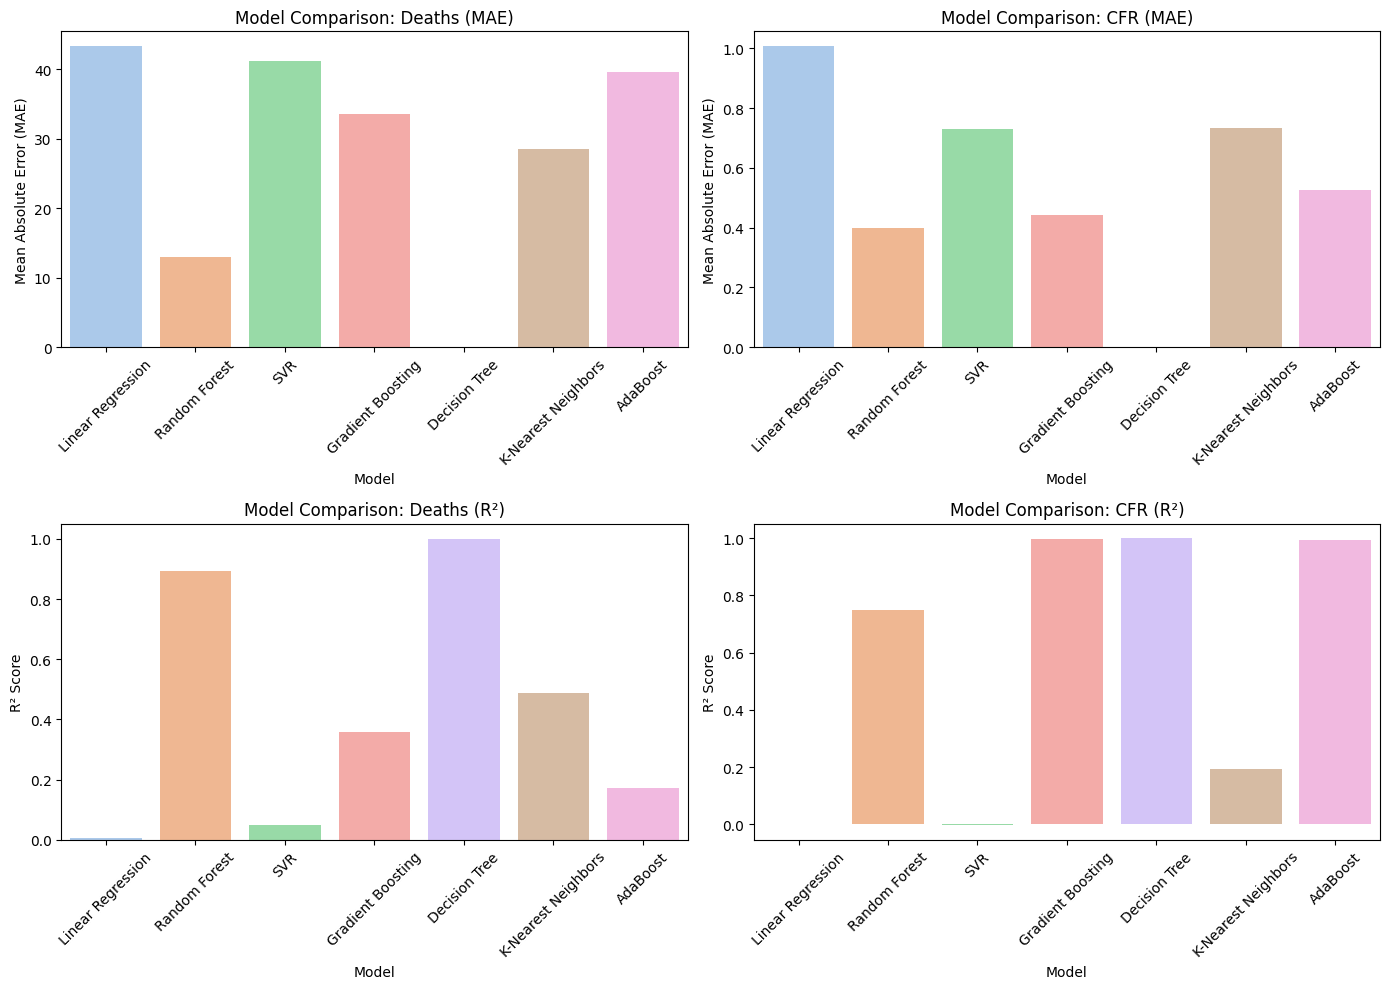

Evaluation metrics saved to models/single_task/Evaluation_Metrics.csv

Best Deaths Model - Test Metrics:
MAE: 78.47724032082823
MSE: 8883.544756959265
R²: -2.272005436566585

Best CFR Model - Test Metrics:
MAE: 0.5609491117193964
MSE: 1.0828299423577001
R²: -0.03356125410978894
Model saved as models/single_task/Decision Tree_Deaths_R2.pkl
Model saved as models/single_task/Decision Tree_Deaths_R2.joblib
Model saved as models/single_task/Decision Tree_CFR_R2.pkl
Model saved as models/single_task/Decision Tree_CFR_R2.joblib

Random Forest - Test Metrics for Deaths:
MAE: 35.459440498516976
MSE: 2046.378864186031
R²: 0.2462735369632416
Model saved as models/single_task/Random_Forest_Deaths_R2.pkl
Model saved as models/single_task/Random_Forest_Deaths_R2.joblib

Random Forest - Test Metrics for CFR:
MAE: 0.42180862348044396
MSE: 0.7477612133066289
R²: 0.28626187070790043
Model saved as models/single_task/Random_Forest_CFR_R2.pkl
Model saved as models/single_task/Random_Forest_CFR_R2.joblib


In [13]:
# Importing necessary libraries for data analysis, model building, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import joblib


def preprocess_training_data(data):
 
    # Drop rows with missing values in critical columns
    data = data.dropna(subset=['Latitude', 'Longitude', 'Deaths', 'Case_Fatality_Ratio'])

    
    X = data[['Latitude', 'Longitude']]
    y_deaths = data['Deaths']
    y_cfr = data['Case_Fatality_Ratio']

    return X, y_deaths, y_cfr


def train_and_evaluate_all_models(X_train, y_deaths_train, y_cfr_train):
   
   
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'SVR': SVR(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'Decision Tree': DecisionTreeRegressor(),
        'K-Nearest Neighbors': KNeighborsRegressor(),
        'AdaBoost': AdaBoostRegressor()
    }

    
    results = []

    for model_name, model in models.items():
        
        model.fit(X_train, y_deaths_train)
        y_deaths_pred = model.predict(X_train)

        # Evaluate model performance for Deaths
        mae_deaths = mean_absolute_error(y_deaths_train, y_deaths_pred)
        mse_deaths = mean_squared_error(y_deaths_train, y_deaths_pred)
        r2_deaths = r2_score(y_deaths_train, y_deaths_pred)

       
        model.fit(X_train, y_cfr_train)
        y_cfr_pred = model.predict(X_train)

        
        mae_cfr = mean_absolute_error(y_cfr_train, y_cfr_pred)
        mse_cfr = mean_squared_error(y_cfr_train, y_cfr_pred)
        r2_cfr = r2_score(y_cfr_train, y_cfr_pred)

      
        results.append({
            'Model': model_name,
            'Deaths_MAE': mae_deaths, 'Deaths_MSE': mse_deaths, 'Deaths_R2': r2_deaths,
            'CFR_MAE': mae_cfr, 'CFR_MSE': mse_cfr, 'CFR_R2': r2_cfr
        })

    return pd.DataFrame(results)

def plot_model_comparison(results_df):
   
    models = results_df['Model']
    deaths_mae = results_df['Deaths_MAE']
    deaths_r2 = results_df['Deaths_R2']
    cfr_mae = results_df['CFR_MAE']
    cfr_r2 = results_df['CFR_R2']
    
   
    palette = "pastel"
    
    plt.figure(figsize=(14, 10))

    # Plotting Deaths - MAE
    plt.subplot(2, 2, 1)
    sns.barplot(x=models, y=deaths_mae, palette=palette)
    plt.title("Model Comparison: Deaths (MAE)")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.xlabel("Model")
    plt.xticks(rotation=45)

    
    plt.subplot(2, 2, 2)
    sns.barplot(x=models, y=cfr_mae, palette=palette)
    plt.title("Model Comparison: CFR (MAE)")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.xlabel("Model")
    plt.xticks(rotation=45)

   
    plt.subplot(2, 2, 3)
    sns.barplot(x=models, y=deaths_r2, palette=palette)
    plt.title("Model Comparison: Deaths (R²)")
    plt.ylabel("R² Score")
    plt.xlabel("Model")
    plt.xticks(rotation=45)

   
    plt.subplot(2, 2, 4)
    sns.barplot(x=models, y=cfr_r2, palette=palette)
    plt.title("Model Comparison: CFR (R²)")
    plt.ylabel("R² Score")
    plt.xlabel("Model")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


def save_evaluation_metrics_to_csv(results_df, file_path="models/single_task/Evaluation_Metrics.csv"):
    """
    Save the evaluation metrics DataFrame to a CSV file.

    Args:
        results_df (pd.DataFrame): DataFrame containing evaluation metrics.
        file_path (str): File path to save the CSV file.
    """
    results_df.to_csv(file_path, index=False)
    print(f"Evaluation metrics saved to {file_path}")


def save_model_with_filename(model, model_name, metric_name):
    """
    Save the trained model with a filename that includes the key metric and its value.

    Args:
        model: Trained model object.
        model_name (str): Name of the model.
        metric_name (str): Name of the evaluation metric.
    """
    pkl_filename = f"models/single_task/{model_name}_{metric_name}.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved as {pkl_filename}")

    joblib_filename = f"models/single_task/{model_name}_{metric_name}.joblib"
    joblib.dump(model, joblib_filename)
    print(f"Model saved as {joblib_filename}")

# Preprocess the training data
X, y_deaths, y_cfr = preprocess_training_data(train_df)


X_train, X_test, y_deaths_train, y_deaths_test, y_cfr_train, y_cfr_test = train_test_split(
    X, y_deaths, y_cfr, test_size=0.2, random_state=42
)

# Train and evaluate all models
evaluation_results = train_and_evaluate_all_models(X_train, y_deaths_train, y_cfr_train)


print(evaluation_results)


plot_model_comparison(evaluation_results)


save_evaluation_metrics_to_csv(evaluation_results)


best_deaths_model_name = evaluation_results.loc[evaluation_results['Deaths_R2'].idxmax()]['Model']
best_cfr_model_name = evaluation_results.loc[evaluation_results['CFR_R2'].idxmax()]['Model']

# Instantiate and train the best models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor()
}

best_deaths_model = models[best_deaths_model_name]
best_cfr_model = models[best_cfr_model_name]

best_deaths_model.fit(X_train, y_deaths_train)
best_cfr_model.fit(X_train, y_cfr_train)


y_deaths_pred_test = best_deaths_model.predict(X_test)
y_cfr_pred_test = best_cfr_model.predict(X_test)


print("\nBest Deaths Model - Test Metrics:")
print(f"MAE: {mean_absolute_error(y_deaths_test, y_deaths_pred_test)}")
print(f"MSE: {mean_squared_error(y_deaths_test, y_deaths_pred_test)}")
print(f"R²: {r2_score(y_deaths_test, y_deaths_pred_test)}")

print("\nBest CFR Model - Test Metrics:")
print(f"MAE: {mean_absolute_error(y_cfr_test, y_cfr_pred_test)}")
print(f"MSE: {mean_squared_error(y_cfr_test, y_cfr_pred_test)}")
print(f"R²: {r2_score(y_cfr_test, y_cfr_pred_test)}")


save_model_with_filename(best_deaths_model, best_deaths_model_name, "Deaths_R2")
save_model_with_filename(best_cfr_model, best_cfr_model_name, "CFR_R2")

random_forest_deaths_model = RandomForestRegressor()
random_forest_cfr_model = RandomForestRegressor()


random_forest_deaths_model.fit(X_train, y_deaths_train)

y_deaths_pred_rf = random_forest_deaths_model.predict(X_test)


print("\nRandom Forest - Test Metrics for Deaths:")
print(f"MAE: {mean_absolute_error(y_deaths_test, y_deaths_pred_rf)}")
print(f"MSE: {mean_squared_error(y_deaths_test, y_deaths_pred_rf)}")
print(f"R²: {r2_score(y_deaths_test, y_deaths_pred_rf)}")

# Save the Random Forest model for Deaths with descriptive filename
save_model_with_filename(random_forest_deaths_model, 'Random_Forest', 'Deaths_R2')


random_forest_cfr_model.fit(X_train, y_cfr_train)


y_cfr_pred_rf = random_forest_cfr_model.predict(X_test)

print("\nRandom Forest - Test Metrics for CFR:")
print(f"MAE: {mean_absolute_error(y_cfr_test, y_cfr_pred_rf)}")
print(f"MSE: {mean_squared_error(y_cfr_test, y_cfr_pred_rf)}")
print(f"R²: {r2_score(y_cfr_test, y_cfr_pred_rf)}")


save_model_with_filename(random_forest_cfr_model, 'Random_Forest', 'CFR_R2')

### Multi-Task Learning for Predicting Deaths and Case Fatality Ratio (CFR)

This code aims to predict two target variables (Deaths and Case Fatality Ratio) simultaneously using various machine learning models and techniques like Multi-Task Learning.

#### Data Preprocessing
The first step in the process is to clean and preprocess the data:
- **Missing Values:** We drop rows where critical columns such as `Latitude`, `Longitude`, `Deaths`, and `Case_Fatality_Ratio` have missing values.
- **Features and Targets:** The features used for prediction are the geographical information `Latitude` and `Longitude`. The target variables for prediction are `Deaths` and `Case_Fatality_Ratio` (CFR).

#### Model Selection and Training
Several machine learning models are considered for the task:
- **Linear Regression**
- **Random Forest Regressor**
- **Support Vector Regressor (SVR)**
- **Gradient Boosting Regressor**

We use **MultiOutputRegressor** to handle the multiple target variables (`Deaths` and `CFR`) simultaneously. This allows each model to predict both targets at once, rather than training separate models for each.

#### Model Evaluation
The evaluation metrics used for assessing model performance are:
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**
- **R² Score**

For each model, we calculate these metrics for both `Deaths` and `CFR` on the training set. The results are stored in a DataFrame for easy comparison between the models.

#### Visualizing Model Performance
To visualize the results:
- We generate two sets of bar plots:
  1. MAE for both `Deaths` and `CFR`.
  2. R² Score for both `Deaths` and `CFR`.
  
These plots help in comparing how well each model performs for both target variables.

#### Saving the Best Model
After evaluating all models, the best model is selected based on the highest R² score for both `Deaths` and `CFR`. This model is then saved using **pickle** and **joblib** for later use.

#### Final Model Evaluation
Once the best model is chosen and trained, it is evaluated on the test data. The test set is used to measure how well the model generalizes to unseen data. The evaluation metrics for both `Deaths` and `CFR` are printed.

#### Summary
This project performs multi-task learning by training models to predict both the number of deaths and the case fatality ratio from geographical data. It uses several regression models and evaluates their performance through key metrics like MAE, MSE, and R² score. The best-performing model is saved for future use.

               Model  Deaths_MAE   Deaths_MSE  Deaths_R2   CFR_MAE  \
0  Linear Regression   43.263886  2625.765718   0.004933  1.006661   
1      Random Forest   13.028982   280.617261   0.893657  0.323688   
2                SVR   41.127714  2504.950667   0.050717  0.729752   
3  Gradient Boosting   33.490797  1697.820787   0.356589  0.442241   

      CFR_MSE    CFR_R2  
0  123.804301  0.003412  
1   23.925215  0.807409  
2  124.627757 -0.003217  
3    0.477050  0.996160  
Best model saved as models/multi_task/Random Forest_Deaths.pkl and models/multi_task/Random Forest_Deaths.joblib
Best model saved as models/multi_task/Random Forest_CFR.pkl and models/multi_task/Random Forest_CFR.joblib
Deaths Model - Test Metrics:
MAE: 35.63827928516614
MSE: 2076.7483453151067
R2: 0.23508778734654756

CFR Model - Test Metrics:
MAE: 0.422405808978923
MSE: 0.7504493009425063
R2: 0.283696090875432


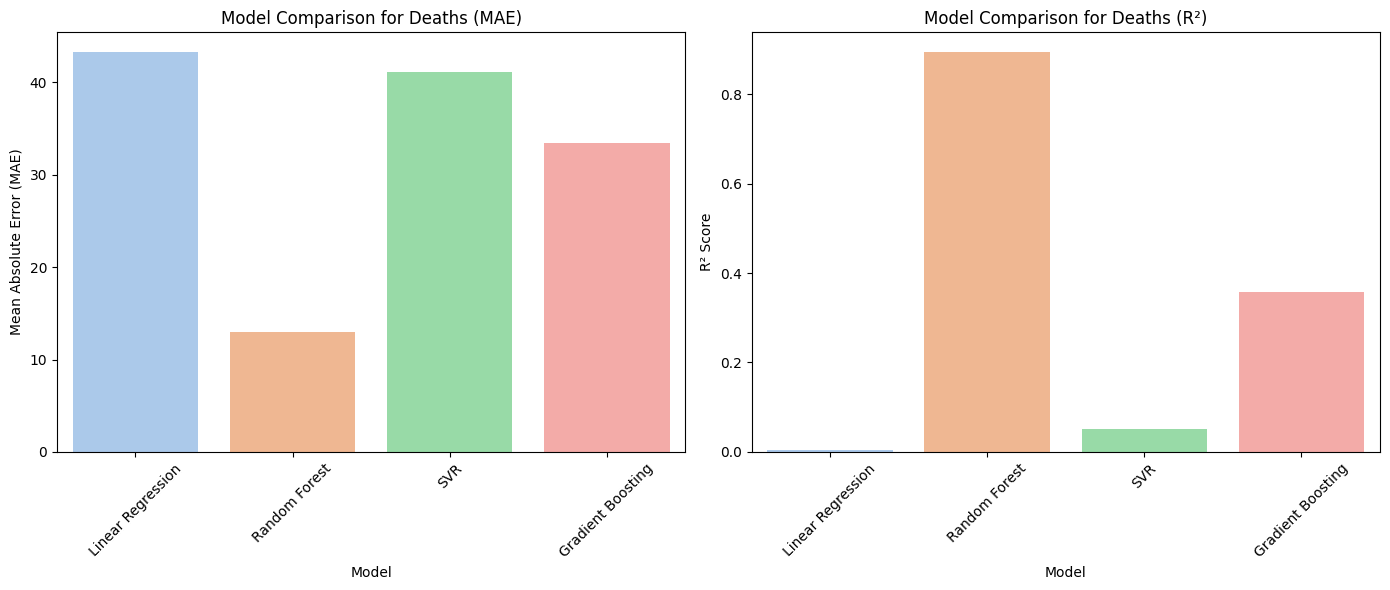

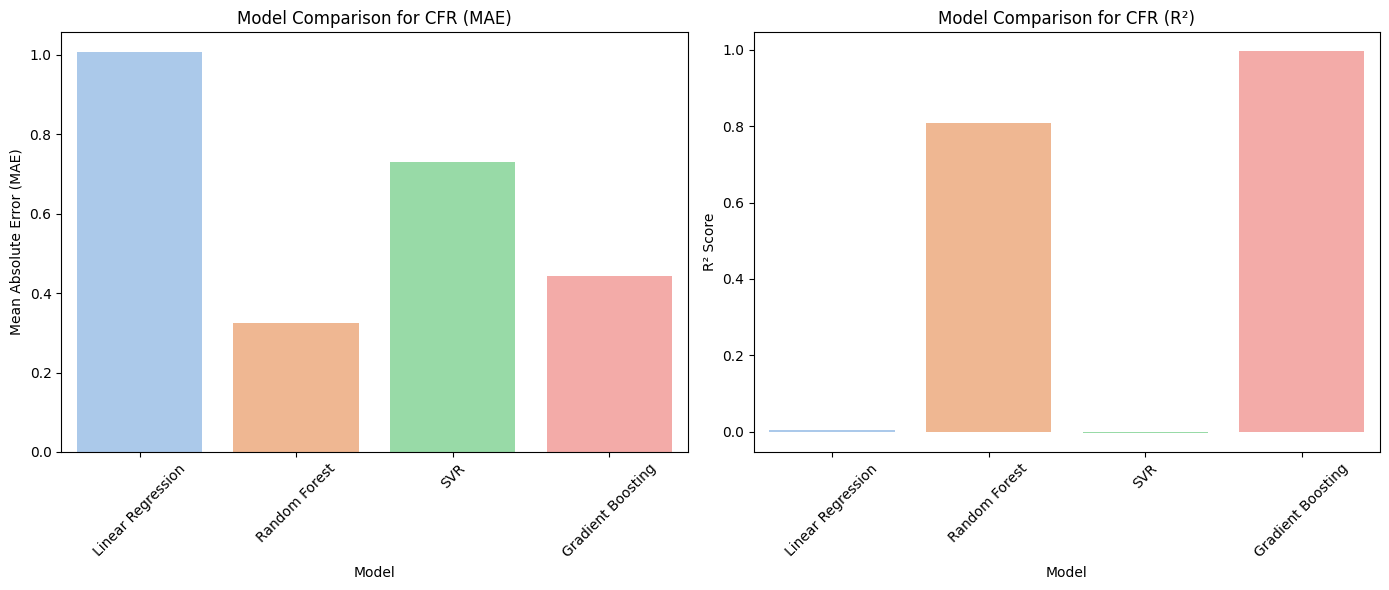

In [14]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

def preprocess_data(df):
    """
    Preprocess the data by:
    - Dropping rows with missing values in key columns.
    - Splitting data into features (X) and targets (y_deaths, y_cfr).
    """
    # Drop rows where critical columns have missing values (Latitude, Longitude, Deaths, Case Fatality Ratio)
    df = df.dropna(subset=['Latitude', 'Longitude', 'Deaths', 'Case_Fatality_Ratio'])
    
  
    X = df[['Latitude', 'Longitude']]
    
   
    y_deaths = df['Deaths']
    y_cfr = df['Case_Fatality_Ratio']
    
    return X, y_deaths, y_cfr


def train_and_evaluate_models(X_train, y_deaths_train, y_cfr_train):
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
        'SVR': SVR(),
        'Gradient Boosting': GradientBoostingRegressor(),
    }

    
    results = []

    for model_name, model in models.items():
     
        multi_task_model = MultiOutputRegressor(model)
        
       
        multi_task_model.fit(X_train, np.column_stack((y_deaths_train, y_cfr_train)))
        
        # Predict Deaths and CFR on the training set
        y_pred = multi_task_model.predict(X_train)
        y_deaths_pred, y_cfr_pred = y_pred[:, 0], y_pred[:, 1]
        
       
        mae_deaths = mean_absolute_error(y_deaths_train, y_deaths_pred)
        mse_deaths = mean_squared_error(y_deaths_train, y_deaths_pred)
        r2_deaths = r2_score(y_deaths_train, y_deaths_pred)
        
        # Evaluate CFR model
        mae_cfr = mean_absolute_error(y_cfr_train, y_cfr_pred)
        mse_cfr = mean_squared_error(y_cfr_train, y_cfr_pred)
        r2_cfr = r2_score(y_cfr_train, y_cfr_pred)
        
        results.append({
            'Model': model_name,
            'Deaths_MAE': mae_deaths, 'Deaths_MSE': mse_deaths, 'Deaths_R2': r2_deaths,
            'CFR_MAE': mae_cfr, 'CFR_MSE': mse_cfr, 'CFR_R2': r2_cfr
        })
    
   
    results_df = pd.DataFrame(results)
    return results_df

def plot_evaluation_results(results_df):
    """
    Visualize the evaluation metrics (MAE and R²) of different models for Deaths and Case Fatality Ratio (CFR).
    Two bar plots are generated for comparison: MAE and R².
    """
    deaths_mae = results_df['Deaths_MAE']
    deaths_r2 = results_df['Deaths_R2']
    cfr_mae = results_df['CFR_MAE']
    cfr_r2 = results_df['CFR_R2']
    
    models = results_df['Model']
    
  
    plt.figure(figsize=(14, 6))
    
    
    plt.subplot(1, 2, 1)
    sns.barplot(x=models, y=deaths_mae, palette="pastel")
    plt.title("Model Comparison for Deaths (MAE)")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.xticks(rotation=45)
    
   
    plt.subplot(1, 2, 2)
    sns.barplot(x=models, y=deaths_r2, palette="pastel")
    plt.title("Model Comparison for Deaths (R²)")
    plt.ylabel("R² Score")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

    # Plotting CFR - MAE with pastel color
    plt.figure(figsize=(14, 6))
    
    # MAE Plot
    plt.subplot(1, 2, 1)
    sns.barplot(x=models, y=cfr_mae, palette="pastel")
    plt.title("Model Comparison for CFR (MAE)")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.xticks(rotation=45)
    
   
    plt.subplot(1, 2, 2)
    sns.barplot(x=models, y=cfr_r2, palette="pastel")
    plt.title("Model Comparison for CFR (R²)")
    plt.ylabel("R² Score")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def save_best_model(best_model, model_name, target_variable):
    """
    Save the trained model as both a pickle file and a joblib file with a name reflecting the target variable.
    """
    
    model_filename = f"models/multi_task/{model_name}_{target_variable}.pkl"
    joblib_filename = f"models/multi_task/{model_name}_{target_variable}.joblib"
    
    
    with open(model_filename, 'wb') as pkl_file:
        pickle.dump(best_model, pkl_file)
    
    
    joblib.dump(best_model, joblib_filename)
    print(f"Best model saved as {model_filename} and {joblib_filename}")
    
# Preprocess training data
X, y_deaths, y_cfr = preprocess_data(train_df)


X_train, X_test, y_deaths_train, y_deaths_test, y_cfr_train, y_cfr_test = train_test_split(
    X, y_deaths, y_cfr, test_size=0.2, random_state=42
)


results_df = train_and_evaluate_models(X_train, y_deaths_train, y_cfr_train)

print(results_df)

# Save Evaluation Metrics to csv file
results_df.to_csv("models/multi_task/Evaluation_Metrics.csv", index=False)


best_model_name = results_df.loc[results_df['Deaths_R2'].idxmax()]['Model']
best_model = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
}[best_model_name]


multi_task_model = MultiOutputRegressor(best_model)
multi_task_model.fit(X_train, np.column_stack((y_deaths_train, y_cfr_train)))

target_variable_deaths = 'Deaths'
save_best_model(multi_task_model, best_model_name, target_variable_deaths)


target_variable_cfr = 'CFR'
save_best_model(multi_task_model, best_model_name, target_variable_cfr)


y_pred_test = multi_task_model.predict(X_test)
y_deaths_pred_test, y_cfr_pred_test = y_pred_test[:, 0], y_pred_test[:, 1]


print("Deaths Model - Test Metrics:")
print(f"MAE: {mean_absolute_error(y_deaths_test, y_deaths_pred_test)}")
print(f"MSE: {mean_squared_error(y_deaths_test, y_deaths_pred_test)}")
print(f"R2: {r2_score(y_deaths_test, y_deaths_pred_test)}")

print("\nCFR Model - Test Metrics:")
print(f"MAE: {mean_absolute_error(y_cfr_test, y_cfr_pred_test)}")
print(f"MSE: {mean_squared_error(y_cfr_test, y_cfr_pred_test)}")
print(f"R2: {r2_score(y_cfr_test, y_cfr_pred_test)}")


plot_evaluation_results(results_df)

### Model Predictions for Deaths and Case Fatality Ratio (CFR)

In this code, we load the previously saved Random Forest models for predicting **Deaths** and **Case Fatality Ratio (CFR)**. These models were stored using `joblib` and are retrieved from the specified file paths. Once the models are loaded, we use the **Latitude** and **Longitude** values from the test dataset (`test_df`) as input features to make predictions for both **Deaths** and **CFR**. The predicted values are then added to the `test_df` DataFrame as new columns, **Predicted_Deaths** and **Predicted_CFR**. Finally, we create a new DataFrame `predictions_df` to store the **Latitude**, **Longitude**, **Predicted_Deaths**, and **Predicted_CFR**, which is then printed for review.

In [15]:

death_model = joblib.load('models/single_task/Random_Forest_Deaths_R2.pkl')
cfr_model = joblib.load('models/single_task/Random_Forest_CFR_R2.pkl')


test_df['Predicted_Deaths'] = death_model.predict(test_df[['Latitude', 'Longitude']])
test_df['Predicted_CFR'] = cfr_model.predict(test_df[['Latitude', 'Longitude']])

# Store the predictions in a new DataFrame
predictions_df = test_df[['Latitude', 'Longitude', 'Predicted_Deaths', 'Predicted_CFR']]


print(predictions_df)

      Latitude   Longitude  Predicted_Deaths  Predicted_CFR
0    41.153300   20.168300        136.260538       1.053873
1   -71.949900   23.347000        112.763514       1.724088
2   -35.473500  149.012400        116.019692       0.100429
3   -34.928500  138.600700         94.950496       0.100952
4    47.516200   14.550100         54.661794       0.512340
..         ...         ...               ...            ...
976  49.213800   -2.135800        112.361667       0.301418
977  -7.946700  -14.355900         56.699952       1.594208
978  52.130700   -3.783700         34.336869       1.006321
979   6.423800  -66.589700         25.647000       1.144533
980  15.552727   48.516388         88.646332       0.986062

[981 rows x 4 columns]


### **Calculating Confirmed Cases Based on the Formula**

**Formula for Case Fatality Ratio (CFR):**

The **Case Fatality Ratio (CFR)** is a measure used to understand the severity of a disease. It is defined as:

**Case Fatality Ratio (CFR)** = (deaths / confirmed cases) × 100
     
Where:
- **deaths** is the total number of people who have died from the disease.
- **confirmed cases** is the total number of people who have been diagnosed with the disease.

However, in some situations, you might only have **CFR** and **deaths** data, and you may need to calculate the **confirmed cases**. To do this, you can rearrange the CFR formula as follows:

**Confirmed Cases** = (deaths / CFR) × 100

By applying this formula, you can determine the **confirmed cases** based on the available **deaths** and **CFR** values.

### **Code Explanation**

1. **Formula Application:**
   - We take the **Predicted_Deaths** from the `predictions_df` DataFrame, which contains the estimated number of deaths for each record.
   - We divide the **Predicted_Deaths** by the **Predicted_CFR** (Case Fatality Ratio).
   - We multiply the result by 100 to get the **Confirmed Cases**.

2. **New Column:** 
   - The calculated **Confirmed Cases** are added as a new column to the `predictions_df` DataFrame with the name `Confirmed_Cases`.

3. **Display the Data:**
   - The updated `predictions_df` is then printed, showing the **Latitude**, **Longitude**, **Predicted_Deaths**, **Predicted_CFR**, and the newly added **Confirmed_Cases**.

This process effectively uses the available predictions of deaths and CFR to estimate the confirmed cases for each data point.

In [16]:

predictions_df['Confirmed_Cases'] = (predictions_df['Predicted_Deaths'] / predictions_df['Predicted_CFR']) * 100


print(predictions_df)

      Latitude   Longitude  Predicted_Deaths  Predicted_CFR  Confirmed_Cases
0    41.153300   20.168300        136.260538       1.053873     12929.504454
1   -71.949900   23.347000        112.763514       1.724088      6540.473060
2   -35.473500  149.012400        116.019692       0.100429    115523.896147
3   -34.928500  138.600700         94.950496       0.100952     94054.861307
4    47.516200   14.550100         54.661794       0.512340     10669.052440
..         ...         ...               ...            ...              ...
976  49.213800   -2.135800        112.361667       0.301418     37277.744251
977  -7.946700  -14.355900         56.699952       1.594208      3556.622286
978  52.130700   -3.783700         34.336869       1.006321      3412.117950
979   6.423800  -66.589700         25.647000       1.144533      2240.827042
980  15.552727   48.516388         88.646332       0.986062      8989.934501

[981 rows x 5 columns]


### Saving to CSV File

In [17]:

predictions_df.to_csv("data/final/predictions.csv", index=False)

print("File Saved Successfully")

File Saved Successfully
